In [12]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import glob
import os
import sys
sys.path.append('segmentation-cnn')
sys.path.append('classification-cnn')
from dataset import tf_dataset
from model import jacard_coef,jacard_coef_loss,DiceLoss
from segment_image import plate_characters
from segment_imageV2 import segmented_image, four_point_transform
import imutils

In [4]:
# Load Model Segmentation List
model_seg_list = glob.glob('../data/segmentation-cnn/models/*')
model_seg_list.sort()
# Load Model Classification List
model_clas_list = glob.glob('../data/classification-cnn/models/*')
model_clas_list.sort()

In [5]:
model_clas_list

['../data/classification-cnn/models/model_8458.h5',
 '../data/classification-cnn/models/model_8883.h5',
 '../data/classification-cnn/models/model_8897.h5',
 '../data/classification-cnn/models/model_9115.h5',
 '../data/classification-cnn/models/model_9449.h5',
 '../data/classification-cnn/models/model_9759.h5',
 '../data/classification-cnn/models/model_9822.h5',
 '../data/classification-cnn/models/model_9826.h5',
 '../data/classification-cnn/models/model_9848.h5',
 '../data/classification-cnn/models/model_9851.h5',
 '../data/classification-cnn/models/model_9859.h5',
 '../data/classification-cnn/models/model_9859_2.h5']

In [6]:

model1 = load_model(model_seg_list[9],custom_objects={'jacard_coef_loss' : jacard_coef_loss,'jacard_coef' : jacard_coef, 'DiceLoss' : DiceLoss})
model2 = load_model(model_seg_list[20],custom_objects={'jacard_coef_loss' : jacard_coef_loss,'jacard_coef' : jacard_coef, 'DiceLoss' : DiceLoss})
model3 = load_model(model_seg_list[14],custom_objects={'jacard_coef_loss' : jacard_coef_loss,'jacard_coef' : jacard_coef, 'DiceLoss' : DiceLoss})
model4 = load_model(model_seg_list[13],custom_objects={'jacard_coef_loss' : jacard_coef_loss,'jacard_coef' : jacard_coef, 'DiceLoss' : DiceLoss})
model5 = load_model(model_seg_list[11],custom_objects={'jacard_coef_loss' : jacard_coef_loss,'jacard_coef' : jacard_coef, 'DiceLoss' : DiceLoss})
# model_classification = load_model(model_clas_list[0])

2022-07-25 17:17:03.570904: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-25 17:17:03.660941: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-25 17:17:03.662315: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-25 17:17:03.664688: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [5]:
model1 = load_model(model_clas_list[3])
model2 = load_model(model_clas_list[4])
model3 = load_model(model_clas_list[5])
model4 = load_model(model_clas_list[10])

2022-07-12 22:07:05.898713: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-12 22:07:05.943802: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-12 22:07:05.944257: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-12 22:07:05.945391: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [7]:
def read_image(image_path,shape,mode): 
    org = cv2.imread(image_path, mode)
    x = cv2.resize(org, shape)
    x = x / 255.0
    x = x.astype(np.float32)
    return x, org

In [8]:
col_names = ['img','mask']
df = pd.read_csv ('segmentation-cnn/original csv/test_dataset.csv',sep=',',header=None,names=col_names)
images = df['img'].tolist()
masks = df['mask'].tolist()


test_dataset = tf_dataset(images, masks, batch_size=16, buffer_size=1000)

448 288


In [11]:
model3.evaluate(test_dataset)

2022-07-10 19:12:34.413155: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 674 of 1000
2022-07-10 19:12:39.314880: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


1563/1563 [==============================] - 656s 410ms/step - loss: -0.9496 - jacard_coef: 0.9496 - DiceLoss: 0.9740


[-0.9495764970779419, 0.9495832324028015, 0.9740452766418457]

In [6]:
"""
Se predicen y se guardan los resutlados de X modelos diferentes de la red de segmentación para comprar las diferencias entre cada uno de ellos
"""
out_path='predsModels/'
modelList=[model1,model2,model3,model4,model5]
for index,item in enumerate(images[:15]):
    dr = out_path + '/' + str(index+1)
    os.mkdir(dr)
    dr = dr + '/'
    img,org = read_image(images[index],(288,448),cv2.IMREAD_COLOR)
    mask,mask_org = read_image(masks[index],(288,448),cv2.IMREAD_COLOR)
    cv2.imwrite(dr + '/' + '1. image.jpg',org)
    cv2.imwrite(dr + '/' + '2. mask.jpg',mask_org)
    img = np.expand_dims(img,axis=0)
    
    for index,model in enumerate(modelList): 
        pred = model.predict(img)
        pred = pred[0]
        pred[pred < 0.5] = 0
        pred[pred >= 0.5] = 255
        pred = cv2.resize(pred,(720,1160),cv2.INTER_NEAREST)
        cv2.imwrite(dr + '/' + '3.' + str(index+1) + '. pred.jpg',pred)

2022-07-12 21:07:36.536185: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


In [9]:
index = 20001 # 19 26
img,_ = read_image(images[index],(288,448),cv2.IMREAD_COLOR)
# imgRes = np.expand_dims(img, axis=0)
imgRes =  [img,img]
maskRes = read_image(masks[index],(288,448),cv2.IMREAD_GRAYSCALE)
mm = np.stack(imgRes,axis=0)
mm.shape

(2, 448, 288, 3)

2022-07-25 17:17:31.535914: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


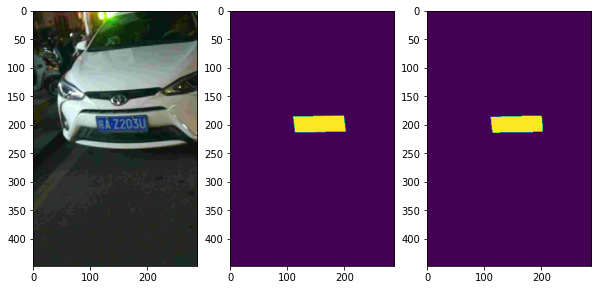

In [10]:
# Muestro la imagen, máscara y prediccion
index = 20001 # 19 26
img,_ = read_image(images[index],(288,448),cv2.IMREAD_COLOR)
imgRes = np.expand_dims(img, axis=0)
maskRes,_ = read_image(masks[index],(288,448),cv2.IMREAD_GRAYSCALE)
rgbImage = img[:,:,::-1]

# Predict
predRes = model5.predict(imgRes)
predRes[predRes < 0.5] = 0
predRes[predRes >= 0.5] = 255

fig = plt.figure(figsize=(10, 10))
plt.subplot(1,3,1)
plt.imshow(rgbImage)
plt.subplot(1,3,2)
plt.imshow(maskRes)
plt.subplot(1,3,3)
plt.imshow(predRes[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[201 187]
 [110 186]
 [113 214]
 [202 213]]


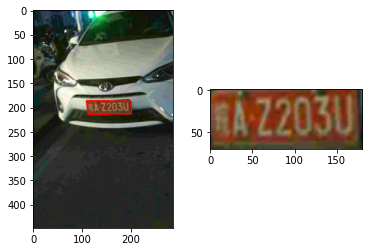

In [8]:
prd = predRes[0].copy()
prd = prd.astype(np.uint8)
prd = cv2.GaussianBlur(prd,(3,3), 0)
cnts = cv2.findContours(prd, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
# loop over the contours
for c in cnts:
	# approximate the contour
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.07 * peri, True)
	# if our approximated contour has four points, then we
	# can assume that we have found our screen
	if len(approx) == 4:
		screenCnt = np.squeeze(approx,axis=1)
		break

heigth = 70
width = 180
    
box = screenCnt
print(box)

pt2 = np.float32([[0,0], [width,0], [0,heigth], [width,heigth]])
if box[0][0] < box[2][0]:
	pt12 = np.float32([box[0],box[3],box[1],box[2]])
else:
	pt12 = np.float32([box[1],box[0],box[2],box[3]])
	

f = cv2.getPerspectiveTransform(pt12,pt2)
f2 = cv2.warpPerspective(img,f,(width,heigth))
# print(screenCnt)
draw = img.copy()
cv2.drawContours(draw, [screenCnt], -1, (255,0 , 0), 2)
plt.subplot(1,2,1)
plt.imshow(draw)
plt.subplot(1,2,2)
plt.imshow(f2)

In [11]:
# Test para etiquetar de la mejor manera posible cada una de las letras y separarlas correctamente


from skimage import measure
from skimage import io
from scipy.ndimage import label

red,img = read_image('output_test/21655/3. perspective.jpg',(180,70),cv2.IMREAD_COLOR)
red,img = read_image('output_test/13248/3. perspective.jpg',(180,70),cv2.IMREAD_COLOR)
red,img = read_image('output_test/3241/3. perspective.jpg',(180,70),cv2.IMREAD_COLOR)
# red,img = read_image('/home/mihai/mat.png',(180,70),cv2.IMREAD_COLOR)
# img = cv2.resize(img,dsize=(1800,700),interpolation=cv2.INTER_CUBIC)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray = gray.astype(np.uint8)

gray = cv2.GaussianBlur(gray,(3,3), 0)


thresh = cv2.threshold(gray, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]


thresh[:10,:] = 0
thresh[60:,:] = 0
thresh[:,:10] = 0
thresh[:,170:] = 0

# thresh = cv2.dilate(thresh,kernel=(5,5),iterations=5)
numLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh,-1,cv2.CV_32S)
# numLabels, labels = cv2.connectedComponents(thresh, connectivity=8)
thresh = thresh.astype(np.float32)
skiLabels = measure.label(thresh,background=-1)

# labels = label(thresh, structure=None, output=None)

print(skiLabels.shape)
# cv2.imwrite('skiLab.png',skiLabels)
print(numLabels)
print(np.unique(skiLabels))
print(np.unique(labels[0]))


component = np.zeros(gray.shape, dtype="uint8")
componentMask = (skiLabels == 10).astype("uint8") * 255

# Apply the mask using the bitwise operator
component = cv2.bitwise_or(component,componentMask)


plt.subplot(1,3,1)
plt.imshow(gray)
plt.subplot(1,3,2)
plt.imshow(thresh,cmap='gray')
plt.subplot(1,3,3)
io.imshow(component,cmap='gray')

[ WARN:0@317.903] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('output_test/21655/3. perspective.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.6.0) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(9, 21, 57, 42)
(9, 56, 57, 77)
(10, 81, 56, 101)
(10, 105, 55, 124)
(11, 133, 55, 140)
(11, 149, 55, 167)


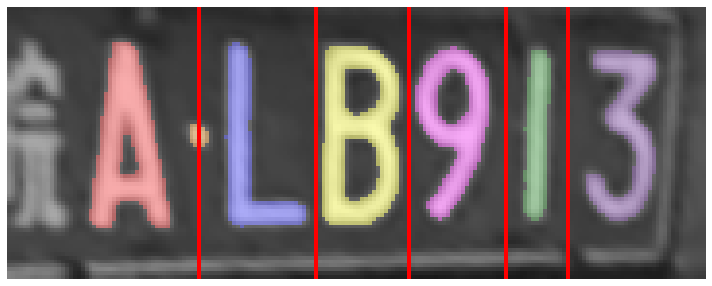

In [36]:
# Test para etiquetar de la mejor manera posible cada una de las letras y separarlas correctamente V2
# Mejor manera encontrada. Binarizar, limpiar bordes, etiquetar, obtener cada una de las letras y coger como separación de dos letras el punto medio de los dos puntos de sus extremos

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from skimage import data
from skimage.filters import threshold_otsu,sobel
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb



image = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
image = cv2.GaussianBlur(image,(3,3), 0)

# apply threshold
thresh = threshold_otsu(image)
thresh = thresh 
bw = closing(image > thresh, square(1))

bw[:10,:] = 0
bw[60:,:] = 0
bw[:,:10] = 0
bw[:,170:] = 0

# remove artifacts connected to image border
cleared = clear_border(bw)

# label image regions
label_image = label(cleared)

[h,w] = label_image.shape
h2 = int(h/2)
numbers = label_image[h2-5:h2+5,:].flatten()
numbers = set(numbers)
uniq = np.unique(label_image)
uniq = [x if x not in numbers else 0 for x in uniq]
for x in uniq:
    label_image[label_image == x] = 0
# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
image_label_overlay = label2rgb(label_image, image=image, bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

rec = []
for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 50:
        # draw rectangle around segmented coins
        print(region.bbox)
        minr, minc, maxr, maxc = region.bbox
        # rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
        #                           fill=False, edgecolor='red', linewidth=2)
        
        # ax.add_patch(rect)
        rec.append(minc)
        rec.append(maxc)
        # image_label_overlay[:,minc] = (255,0,0)
        # image_label_overlay[:,maxc] = (255,0,0)
rec.sort()
res = []
for index in range(1,len(rec)-1,2):
    sep = int((rec[index+1] - rec[index]) * 0.5)
    sep = rec[index] + sep
    res.append(sep)
    
for i in res:
    image_label_overlay[:,i] = (255,0,0)
    
ax.imshow(image_label_overlay)       

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [26]:
regionprops(label_image)[0]

[[[286. 227.]]

 [[ 35. 198.]]

 [[284. 199.]]

 [[ 41. 222.]]]


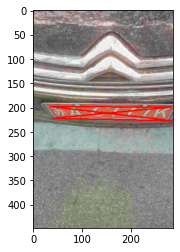

In [215]:
# Test para obtener con detector de harris para obtener las cordenadas de los 4 vertices de la imagen para la obtención de las perspectiva
prd = predRes[0].copy()
prd = prd.astype(np.uint8)
prd = cv2.GaussianBlur(prd,(3,3), 0)
kernel = np.ones((1, 1), 'uint8')
prd = cv2.dilate(prd,kernel,iterations=2)

prd = cv2.copyMakeBorder(prd, 1, 1, 1, 1, cv2.BORDER_CONSTANT, None, value = 0)
corners = cv2.goodFeaturesToTrack(prd,maxCorners=4,qualityLevel=0.05,minDistance=5,blockSize=10,useHarrisDetector=True)
draw = img.copy()
print(corners)

corners = np.int0(corners)
corners = np.squeeze(corners,axis=1)
cv2.drawContours(draw, [corners], -1, (1,0 , 0), 2)
plt.imshow(draw)

[[ 79 205]
 [185 204]
 [186 171]
 [ 79 172]]


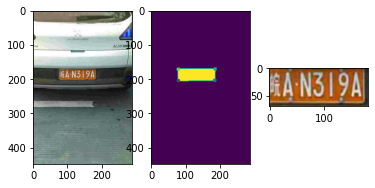

In [129]:
print(corners)
circ = prd.copy()
for i in range(0,4):
    cv2.circle(circ,(corners[i][0], corners[i][1]), 5, (i+1)*50, -1)
wrp, rect = four_point_transform(img.copy(), corners)

plt.subplot(1,3,1)
plt.imshow(img)
plt.subplot(1,3,2)
plt.imshow(circ)
plt.subplot(1,3,3)
plt.imshow(wrp)